In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
import seaborn as sns
import os

os.chdir('../../')
os.getcwd()

'/home/max/mcrc-cetuximab-analysis'

## Load data

In [ ]:
annotation_df = pd.read_csv("data/useful_ann_no_metastases_maxim.csv")

expression_df = pd.read_csv("data/log2_tpms_from_fpkm_hgnc_no_metastases_maxim.csv", index_col=0)

# Show the column names
print("Annotation columns:\n", annotation_df.columns)

# Show unique value counts for each column (up to 20 values each)
for col in annotation_df.columns:
    unique_vals = annotation_df[col].unique()
    print(f"\nColumn: {col} — Unique values: {len(unique_vals)}")
    print(unique_vals[:20])  # show up to first 20 values

Annotation columns:
 Index(['tissue', 'time point', 'treatment response', 'patient_id',
       'sample_title', 'gsm_id'],
      dtype='object')

Column: tissue — Unique values: 1
['primary tumor (colorectum)']

Column: time point — Unique values: 2
['post-treatment' 'pre-treatment']

Column: treatment response — Unique values: 3
['non-PD' 'unknown' 'PD']

Column: patient_id — Unique values: 52
[ 1  2  3  4  6  8 29 32  7 12 13 10 11 14 15 16 61  9 18 19]

Column: sample_title — Unique values: 77
['POST-R-001' 'PAIR-R-001-pre' 'POST-R-002' 'PAIR-R-002' 'PAIR-R-003'
 'PRE-R-001' 'PAIR-R-004' 'POST-R-004' 'PAIR-R-006' 'PRE-R-002' 'PAIR-04'
 'PAIR-R-008' 'PAIR-29' 'PAIR-32' 'PRE-R-006' 'PRE-R-007' 'PAIR-R-012'
 'PAIR-R-013' 'POST-R-010' 'POST-R-011']

Column: gsm_id — Unique values: 80
['GSM5575333' 'GSM5575334' 'GSM5575336' 'GSM5575337' 'GSM5575339'
 'GSM5575342' 'GSM5575343' 'GSM5575347' 'GSM5575349' 'GSM5575350'
 'GSM5575351' 'GSM5575356' 'GSM5575359' 'GSM5575360' 'GSM5575363'
 'GSM5575

## Create PCA plot by merging two expressions with annotations

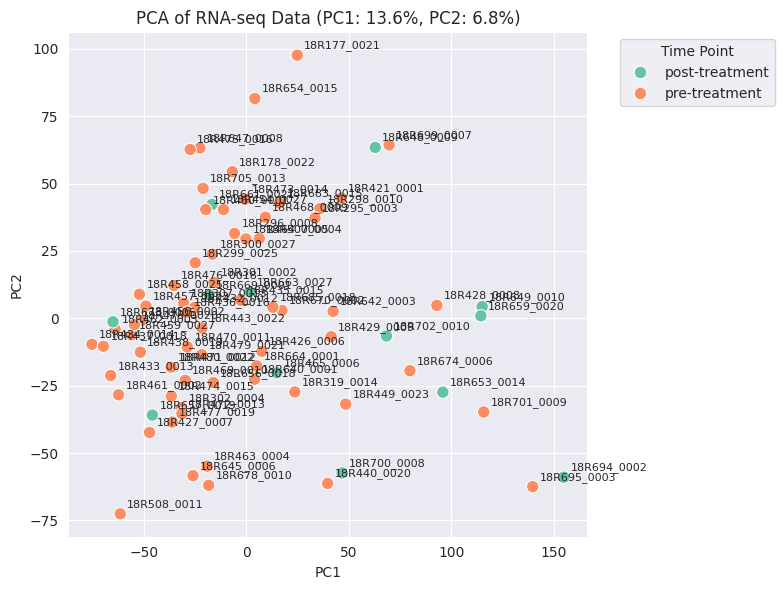

In [3]:
# Merge expression and metadata on 'sample_id'
merged_df = pd.merge(expression_df, annotation_df, left_index=True, right_index=True, how='inner')

# Separate numeric (genes) and metadata
gene_columns = [col for col in expression_df.columns if col not in ['sample_id']]  # Exclude non-gene columns
expression_numeric = merged_df[gene_columns]
metadata = merged_df[['time point']]  # Or other metadata columns

# Step 1: Scale the gene expression data (genes are now columns!)
#scaler = StandardScaler()
#scaled_expression = scaler.fit_transform(expression_numeric)

# Step 2: PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(expression_numeric)

# Step 3: Create PCA DataFrame
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])
pca_df['sample_id'] = merged_df.index.values  # Add sample IDs
pca_df['time point'] = merged_df['time point'].values  # Add time points

# Step 4: Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='time point', palette='Set2', s=80)
plt.title(f'PCA of RNA-seq Data (PC1: {pca.explained_variance_ratio_[0]*100:.1f}%, PC2: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Time Point', bbox_to_anchor=(1.05, 1), loc='upper left')
for i, row in pca_df.iterrows():
    plt.annotate(row['sample_id'], (row['PC1'], row['PC2']), xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.tight_layout()
plt.show()


# --- Outlier Detection ---

## Method 1: Mahalanobis Distance

In [4]:
cov_matrix = np.cov(pca_results.T)
mean_pc = np.mean(pca_results, axis=0)
inv_cov = np.linalg.inv(cov_matrix)
pca_df['mahalanobis_distance'] = [mahalanobis(x, mean_pc, inv_cov) for x in pca_results]

# Identify outliers (top 5% farthest)
threshold = np.percentile(pca_df['mahalanobis_distance'], 95)
outliers = pca_df[pca_df['mahalanobis_distance'] > threshold]
print("Outliers (Mahalanobis Distance > 95th percentile):")
print(outliers[['sample_id', 'time point', 'mahalanobis_distance']].sort_values('mahalanobis_distance', ascending=False))

Outliers (Mahalanobis Distance > 95th percentile):
      sample_id      time point  mahalanobis_distance
7   18R694_0002  post-treatment              3.422921
35  18R695_0003   pre-treatment              3.217121
17  18R177_0021   pre-treatment              2.729600
66  18R701_0009   pre-treatment              2.449247


## Method 2: Z-score (on PCs)

In [5]:
for pc in ['PC1', 'PC2']:
    pca_df[f'{pc}_zscore'] = (pca_df[pc] - pca_df[pc].mean()) / pca_df[pc].std()
zscore_outliers = pca_df[(np.abs(pca_df['PC1_zscore']) > 3) | (np.abs(pca_df['PC2_zscore']) > 3)]
print("\nOutliers (Z-score > |3|):")
print(zscore_outliers[['sample_id', 'time point', 'PC1_zscore', 'PC2_zscore']])


Outliers (Z-score > |3|):
      sample_id      time point  PC1_zscore  PC2_zscore
71  18R697_0005  post-treatment    2.752154    4.109611
77  18R294_0001   pre-treatment    2.659658    4.304984
